In [5]:
# Data: time-serie data from smartwatch or smartwatch data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as spio

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path_1xn = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
# watch_txn = pd.read_csv(data_path_1xn)
# % cd ../
# % cd /Users/arasdar/
# # Linux-Ubuntu
# data_path = '/home/arasdar/data/Training_data/DATA_01_TYPE01.mat'
# Macbook
data_path = '/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat'
watch = spio.loadmat(data_path)
data = watch['sig']
data = np.array(data)
data.shape, watch['sig'].size/6

# Normalizing each batch of the data, each batch = each file
# Can we normalize them all at the same time?
mean = np.mean(data, axis=1)
var = np.var(data, axis=1)
std = np.sqrt(var)
mean.shape, var.shape, std.shape
mean = mean.reshape(-1, 1)
std = std.reshape(-1, 1)
mean.shape, std.shape
data_norm = (data - mean)/std
data.shape, data_norm.shape

((6, 37937), (6, 37937))

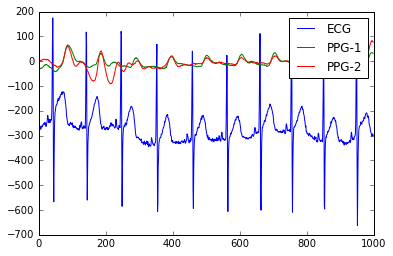

In [6]:
# The features/ channels of the data = ['HR-ECG', 'HR-PPG', 'ACC-X', 'ACC-Y', 'ACC-Z']
plt.plot(data[0, :1000], label='ECG')
plt.plot(data[1, :1000], label='PPG-1')
plt.plot(data[2, :1000], label='PPG-2')
# plt.plot(x_sig[3, :1000], label='ACC-X')
# plt.plot(x_sig[4, :1000], label='SCC-Y')
# plt.plot(x_sig[5, :1000], label='ACC-Z')
plt.legend()
plt.show()

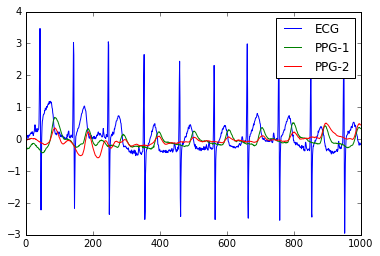

In [7]:
# The features/ channels of the data = ['HR-ECG', 'HR-PPG', 'ACC-X', 'ACC-Y', 'ACC-Z']
plt.plot(data_norm[0, :1000], label='ECG')
plt.plot(data_norm[1, :1000], label='PPG-1')
plt.plot(data_norm[2, :1000], label='PPG-2')
# plt.plot(x_sig[3, :1000], label='ACC-X')
# plt.plot(x_sig[4, :1000], label='SCC-Y')
# plt.plot(x_sig[5, :1000], label='ACC-Z')
plt.legend()
plt.show()

((37937, 5), (37937, 1), (37937, 1))

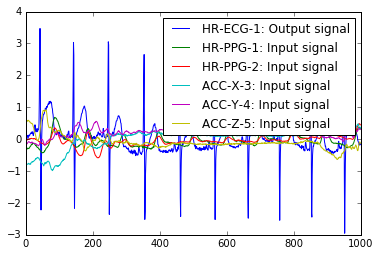

In [26]:
# ECG
Y = data_norm[0]
X = data_norm[1:]
Y.shape, X.shape
Y = Y.reshape(1, -1)
Y.shape, X.shape
plt.plot(Y[0, :1000], label='HR-ECG-1: Output signal')
plt.plot(X[0, :1000], label='HR-PPG-1: Input signal')
plt.plot(X[1, :1000], label='HR-PPG-2: Input signal')
plt.plot(X[2, :1000], label='ACC-X-3: Input signal')
plt.plot(X[3, :1000], label='ACC-Y-4: Input signal')
plt.plot(X[4, :1000], label='ACC-Z-5: Input signal')
plt.legend()
X_train = X.T
Y_train = Y.T
X_train.shape, Y_train.shape
Y_train_in = Y_train[1:, :]
Y_train_in.shape, Y_train.shape
firstrow = np.zeros((1, 1))
firstrow.shape, Y_train_in.shape
Y_train_in = np.row_stack((firstrow, Y_train_in))
Y_train_in.shape, Y_train_in[:5], Y_train[:5]
Y_train_out = Y_train.copy()
X_train.shape, Y_train_in.shape, Y_train_out.shape

In [27]:
# Model or Network
import impl.layer as l
import impl.utils as util
import impl.NN as nn

class GRU(nn.NN):

    def __init__(self, D, H, L, C):
        self.D = D # number of input dimensions
        self.H = H # number of hidden units
        self.L = L # number of hidden layers
        self.C = C # number of output classes/dimensions
        self.losses = {'train':[], 'train2':[], 'train3':[]} #, 'valid':[], 'test':[]
        super().__init__(D, D, H, None, None, loss='cross_ent', nonlin='relu')

    def _init_model(self, D, C, H):
        # Input sequence model parameters
        Z = H + D
        params_in_seq = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(D / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        
        # output sequence model parameters
        Z = H + C
        params_out_seq = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, C) / np.sqrt(C / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, C))
        )

        # Model parameters
        self.model = []
        num_modes = 2 # num of modality as the source of sequences
        for mode in range(num_modes):
            self.model.append([])
            
        # Number of layers for each mode
        for layer in range(self.L):
            self.model[0].append(params_in_seq)
            self.model[1].append(params_out_seq)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_one_hot = X.copy()
        h_old = h.copy()

        X = np.column_stack((h_old, X_one_hot))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X_prime = np.column_stack((hr * h_old, X_one_hot))
        hh, hh_cache = l.fc_forward(X_prime, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        h = (1. - hz) * h_old + hz * hh

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (
            X, X_prime, h_old, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache,
            hh, hh_cache, hh_tanh_cache, h, y_cache
        )

        return y, h, cache

    def backward(self, dy, dh, cache):
        X, X_prime, h_old, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, h, y_cache = cache
        
        dh_next = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next

        dhh = hz * dh
        dh_old1 = (1. - hz) * dh
        dhz = hh * dh - h_old * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dX_prime, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh_prime = dX_prime[:, :self.H]
        dh_old2 = hr * dh_prime

        dhr = h_old * dh_prime
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_old3 = dX[:, :self.H]

        dh = dh_old1 + dh_old2 + dh_old3
        dX = dX[:, self.H:]

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, XY_train, h):
        # Adding the output layer cache
        caches = []
        num_modes = 2
        for mode in range(num_modes):
            caches.append([])
        
        h_init = h.copy()
        h = []
        for layer in range(self.L):
            h.append(h_init.copy())
            caches[0].append([])
            caches[1].append([])
            
        ys = []
        X, Y = XY_train
        
        # Input sequence
        for x in X:
            x= x.reshape(1, -1) # mat_1xn
            
            for layer in range(self.L):
                _, h[layer], cache = self.forward(x, h[layer], self.model[0][layer])
                caches[0][layer].append(cache)
                    
        # Output sequence
        for y in Y:
            y= y.reshape(1, -1) # mat_1xn
            
            for layer in range(self.L):
                y, h[layer], cache = self.forward(y, h[layer], self.model[1][layer])
                caches[1][layer].append(cache)

            # Output list
            ys.append(y)
            
        return ys, caches

    def l2_regression_NEW(self, y_pred, y_train):
        m = y_pred.shape[0]

        # (F(x)-y)^2: convex as X^2 or (aX-b)^2
        data_loss = 0.5 * np.sum((y_pred - y_train)**2) / m
    
        return data_loss

    def dl2_regression_NEW(self, y_pred, y_train):
        m = y_pred.shape[0]

        # (F(x)-y)^2: convex as X^2 or (aX-b)^2
        dy = (y_pred - y_train) / m

        return dy

    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.l2_regression_NEW(y_pred, y)/ y_train.shape[0]
            dy = self.dl2_regression_NEW(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        num_modes = 2
        for _ in range(num_modes):
            grad.append([])
            grads.append([])
        
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            
        for mode in range(num_modes):
            for layer in range(self.L):
                grad[mode].append({key: np.zeros_like(val) for key, val in self.model[mode][layer].items()})
                grads[mode].append({key: np.zeros_like(val) for key, val in self.model[mode][layer].items()})

        for mode in range(num_modes):
            for t in reversed(range(len(dys))):
                dX = dys[t].copy()
                for layer in reversed(range(self.L)):
                    dX, dh[layer], grad[mode][layer] = self.backward(dX, dh[layer], caches[mode][layer][t])
                    for k in grad[mode][layer].keys():
                        grads[mode][layer][k] += grad[mode][layer][k]
                
        return dX, grads

In [15]:
from sklearn.utils import shuffle as skshuffle
import impl.constant as c

# Read and normalize one batch/file of data
def read_data(data_path):
    band = spio.loadmat(data_path)
    data = band['sig']
    data = np.array(data)
    #     data.shape, band['sig'].size/6

    # Normalizing each batch of the data, each batch = each file
    # Can we normalize them all at the same time?
    mean = np.mean(data, axis=1)
    var = np.var(data, axis=1)
    std = np.sqrt(var)
    mean.shape, var.shape, std.shape
    mean = mean.reshape(-1, 1)
    std = std.reshape(-1, 1)
    mean.shape, std.shape
    data_norm = (data - mean)/std
    #     print(data.shape, data_norm.shape)
    
    # ECG
    Y = data_norm[0]
    X = data_norm[1:]
    # Y.shape, X.shape
    Y = Y.reshape(1, -1)
    # Y.shape, X.shape
    X = X.T
    Y = Y.T
    #     print(X_train.shape, Y_train.shape)
    return X, Y

def get_minibatch(X, y, minibatch_size, shuffle=True):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, Y_train, alpha, mb_size, n_iter, print_after):
    minibatches = get_minibatch(X_train, Y_train, mb_size, shuffle=False)
    
    M, R = [], []
    for layer in range(nn.L+1):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})

    beta1 = .9
    beta2 = .999
    state = nn.initial_state()

    # Epochs
    for iter in range(1, n_iter + 1):

        # Minibatches/ Stochasticity
        print('The number of minibatches in a sequence for each epoch iteration: {}'.format (len(minibatches)))
        for idx in range(len(minibatches)):
            
            # Gradients
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            
            # Descend
            for layer in range(nn.L+1):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = util.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = util.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))

                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + c.eps)

        # Print loss in each epoch
        if iter % print_after == 0:
            print('Iter-{} training loss: {:.4f}'.format(iter, loss))

        # Drawing the learning curve for loss (Error/loss curve)
        nn.losses['train'].append(loss)

    return nn

In [19]:
def adam_rnn_NEW(nn, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L+1):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})

    beta1 = .9
    beta2 = .999
    state = nn.initial_state()
    n_files = 12

    # Epochs
    for iter in range(1, n_iter + 1):

        # Read the new file, normalize it, and separate it into input and target
        for file_num in range(1, n_files+1):
            
            #             if file_num == 1: data_path = '/Users/arasdar/data/Training_data/DATA_{:02}_TYPE01.mat'.format(file_num)
            #             else: data_path = '/Users/arasdar/data/Training_data/DATA_{:02}_TYPE02.mat'.format(file_num)
            if file_num == 1: data_path = '/home/arasdar/data/Training_data/DATA_{:02}_TYPE01.mat'.format(file_num)
            else: data_path = '/home/arasdar/data/Training_data/DATA_{:02}_TYPE02.mat'.format(file_num)
            print(data_path)

            # Read the mat files, normalize each batch of them, and seperate the output and input
            X_train, Y_train = read_data(data_path=data_path)

            # Minibatches/ Stochasticity
            minibatches = get_minibatch(X_train, Y_train, mb_size, shuffle=False)
            print('The number of minibatches in a sequence for each epoch iteration: {}'.format (len(minibatches)))

            for idx in range(len(minibatches)):

                # Gradients
                X_mini, y_mini = minibatches[idx]
                ys, caches = nn.train_forward(X_mini, state)
                loss, dys = nn.loss_function(y_mini, ys)
                _, grads = nn.train_backward(dys, caches)

                # Descend
                for layer in range(nn.L+1):
                    for k in grads[layer].keys(): #key, value: items
                        M[layer][k] = util.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                        R[layer][k] = util.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                        m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                        r_k_hat = R[layer][k] / (1. - (beta2**(iter)))

                        nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + c.eps)
                        
                # Every minibatch - Drawing the learning curve for loss (Error/loss curve)
                nn.losses['train3'].append(loss)
                        
            # Every single file - Drawing the learning curve for loss (Error/loss curve)
            nn.losses['train2'].append(loss)

        # Each epoch - Drawing the learning curve for loss (Error/loss curve)
        nn.losses['train'].append(loss)
        
        # Print loss in each epoch
        if iter % print_after == 0:
            print('Iter-{} file number-{} training loss: {:.4f}'.format(iter, file_num, loss))

    return nn

In [20]:
# hyper parameters
n_iter = 1000 # epochs
print_after = 10 # print loss of train, valid, and test
time_step = 200 # width of the model or minibatch size
alpha = 1e-3 # learning_rate
num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
num_hidden_layers = 4 # depth or number of hidden layer
num_input_units = X_train.shape[1] # number of input features/dimensions
num_output_units = Y_train.shape[1]

In [ ]:
net = GRU(D=num_input_units, H=num_hidden_units, L=num_hidden_layers, C=num_output_units)

# adam_rnn(nn=net, X_train=X_train, Y_train=Y_train, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)
adam_rnn_NEW(nn=net, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

/home/arasdar/data/Training_data/DATA_01_TYPE01.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_02_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_03_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 180
/home/arasdar/data/Training_data/DATA_04_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_05_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_06_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 192
/home/arasdar/data/Training_data/DATA_07_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 184
/home/arasdar/data/Training_data/DATA_08_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 205
/home/arasdar/data/Train

/home/arasdar/data/Training_data/DATA_09_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Training_data/DATA_10_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Training_data/DATA_11_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 183
/home/arasdar/data/Training_data/DATA_12_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_01_TYPE01.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_02_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_03_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 180
/home/arasdar/data/Training_data/DATA_04_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Train

/home/arasdar/data/Training_data/DATA_04_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_05_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_06_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 192
/home/arasdar/data/Training_data/DATA_07_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 184
/home/arasdar/data/Training_data/DATA_08_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 205
/home/arasdar/data/Training_data/DATA_09_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Training_data/DATA_10_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Training_data/DATA_11_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 183
/home/arasdar/data/Train

/home/arasdar/data/Training_data/DATA_12_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_01_TYPE01.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_02_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_03_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 180
/home/arasdar/data/Training_data/DATA_04_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_05_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_06_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 192
/home/arasdar/data/Training_data/DATA_07_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 184
/home/arasdar/data/Train

/home/arasdar/data/Training_data/DATA_07_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 184
/home/arasdar/data/Training_data/DATA_08_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 205
/home/arasdar/data/Training_data/DATA_09_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Training_data/DATA_10_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Training_data/DATA_11_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 183
/home/arasdar/data/Training_data/DATA_12_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_01_TYPE01.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_02_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Train

/home/arasdar/data/Training_data/DATA_03_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 180
/home/arasdar/data/Training_data/DATA_04_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_05_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_06_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 192
/home/arasdar/data/Training_data/DATA_07_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 184
/home/arasdar/data/Training_data/DATA_08_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 205
/home/arasdar/data/Training_data/DATA_09_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Training_data/DATA_10_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Train

/home/arasdar/data/Training_data/DATA_10_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Training_data/DATA_11_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 183
/home/arasdar/data/Training_data/DATA_12_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_01_TYPE01.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_02_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_03_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 180
/home/arasdar/data/Training_data/DATA_04_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_05_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Train

/home/arasdar/data/Training_data/DATA_06_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 192
/home/arasdar/data/Training_data/DATA_07_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 184
/home/arasdar/data/Training_data/DATA_08_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 205
/home/arasdar/data/Training_data/DATA_09_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Training_data/DATA_10_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Training_data/DATA_11_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 183
/home/arasdar/data/Training_data/DATA_12_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
Iter-40 file number-12 training loss: 3.2683
/home/arasdar/data/Training_data/DATA_01_TYPE01.mat
The number of minibatches in a sequence for each 

/home/arasdar/data/Training_data/DATA_01_TYPE01.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_02_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_03_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 180
/home/arasdar/data/Training_data/DATA_04_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_05_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_06_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 192
/home/arasdar/data/Training_data/DATA_07_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 184
/home/arasdar/data/Training_data/DATA_08_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 205
/home/arasdar/data/Train

/home/arasdar/data/Training_data/DATA_08_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 205
/home/arasdar/data/Training_data/DATA_09_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Training_data/DATA_10_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Training_data/DATA_11_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 183
/home/arasdar/data/Training_data/DATA_12_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_01_TYPE01.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_02_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_03_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 180
/home/arasdar/data/Train

/home/arasdar/data/Training_data/DATA_04_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_05_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_06_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 192
/home/arasdar/data/Training_data/DATA_07_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 184
/home/arasdar/data/Training_data/DATA_08_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 205
/home/arasdar/data/Training_data/DATA_09_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Training_data/DATA_10_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 191
/home/arasdar/data/Training_data/DATA_11_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 183
/home/arasdar/data/Train

/home/arasdar/data/Training_data/DATA_11_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 183
/home/arasdar/data/Training_data/DATA_12_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_01_TYPE01.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_02_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 190
/home/arasdar/data/Training_data/DATA_03_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 180
/home/arasdar/data/Training_data/DATA_04_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_05_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 187
/home/arasdar/data/Training_data/DATA_06_TYPE02.mat
The number of minibatches in a sequence for each epoch iteration: 192
/home/arasdar/data/Train

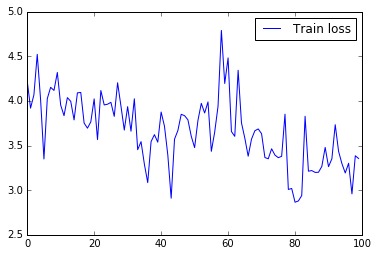

In [56]:
# Display the learning curve and losses for training, validation, and testing
% matplotlib inline
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.legend()